## Imports

In [28]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from CellAnalyzer import CellAnalyzer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load CellAnalyzer model

In [47]:
virus = "229E" # "229E" or "MERS"
in_path = "../imaging_data/21122022_images_jinglecells_SO_AK/" + virus
ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


## Tables

### Inspect raw cell means as tables, grouped by different levels

In [48]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,sample_id,cilia_mean,cilia_mean_log10,inf_mean,inf_mean_log10,inf,cilia,cil_inf_pop
cell_id,,,,,,,,,,,
1201,33mock,BEC6,2,BEC6_2,6839.446999,3.835021,3534.795019,3.548364,partial,positive,cil_pos_inf_par
1202,33mock,BEC6,2,BEC6_2,5185.324748,3.714776,3417.686450,3.533732,partial,negative,cil_neg_inf_par
1203,33mock,BEC6,2,BEC6_2,6587.053950,3.818691,3781.516859,3.577666,partial,negative,cil_neg_inf_par
1204,33mock,BEC6,2,BEC6_2,7844.070552,3.894541,3199.999387,3.505150,negative,positive,cil_pos_inf_neg
1205,33mock,BEC6,2,BEC6_2,6220.638658,3.793835,2820.527227,3.450330,negative,negative,cil_neg_inf_neg


Per condition:

In [49]:
cells_df.groupby('condition')[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                  mean          std         mean          std
condition                                                    
229E       6226.766657  1803.515045  1979.604508  1109.308211
33mock     7630.998331  2275.585225  3026.432274   261.242782

Per condition × donor:

In [50]:
cells_df.groupby(['condition', 'donor'])[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                        mean          std         mean          std
condition donor                                                    
229E      BEC5   5298.672359  1660.934420  1344.615342  1103.461626
          BEC6   7011.552276  1527.374645  2516.543877   783.875706
33mock    BEC5   9594.972225  1614.928491  2848.447068   186.358174
          BEC6   6661.801373  1898.782323  3114.265784   247.954425

Per replicate (to detect batch effects):

In [51]:
cells_df.groupby(['condition', 'donor', 'replicate'])[['cilia_mean', 'inf_mean']].aggregate(["mean", "std"])

cilia_mean                  inf_mean             
                                  mean          std         mean          std
condition donor replicate                                                    
229E      BEC5  1          6214.298377  1722.375843   652.291987   238.501073
                2          4743.250754   875.183502   522.831977    46.479089
                3          4288.047376   937.939728  2436.263548  1013.954658
          BEC6  1          7011.552276  1527.374645  2516.543877   783.875706
33mock    BEC5  1          9594.972225  1614.928491  2848.447068   186.358174
          BEC6  1          7511.270289  1942.709156  3191.857075   239.713169
                2          5779.756952  1381.671499  3033.699016   230.340795

## Plots

### Visualize raw cell means

In [52]:
df_to_show = cells_df.copy()

Visualize conditions

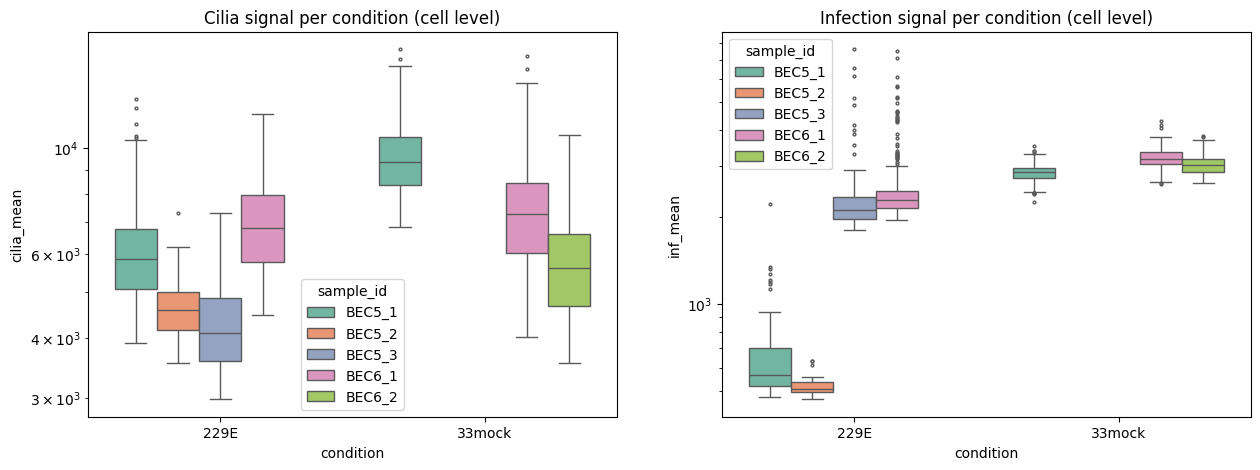

In [53]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(data=df_to_show, x='condition', y='cilia_mean', hue = "sample_id", palette="Set2", ax=ax[0], log_scale=True, fliersize = 2)
sns.boxplot(data=df_to_show, x='condition', y='inf_mean', hue = "sample_id", palette="Set2", ax=ax[1], log_scale=True, fliersize = 2)
ax[0].set_title('Cilia signal per condition (cell level)')
ax[1].set_title('Infection signal per condition (cell level)')
plt.show()

Visualize samples

In [65]:
# Copy threshold values here if available
inf_threshs = [3.3048686427237315, 3.886746802411588] if virus == "MERS" else [3.5164063539947428, 3.5905367908489296]
cilia_thresh = [3.453369860261881] if virus == "MERS" else [3.830079323048743]

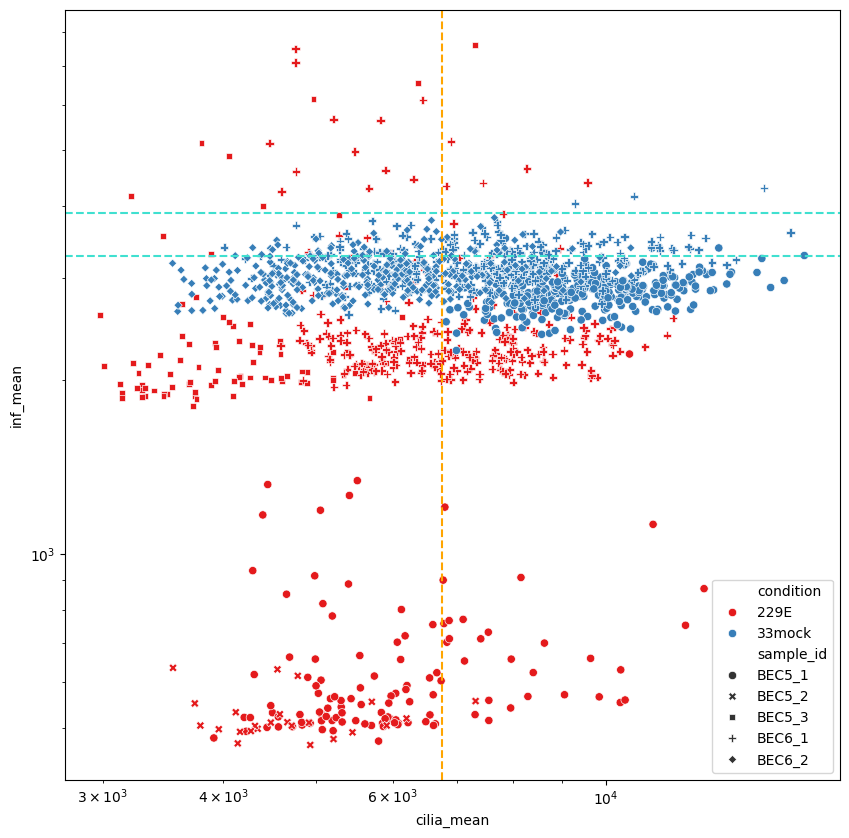

In [66]:
fig, ax = plt.subplots(figsize=(10, 10))
# Create a scatter plot for the two conditions
sns.scatterplot(data=df_to_show, x='cilia_mean', y='inf_mean', hue="condition", palette="Set1", style="sample_id", ax=ax)
# Add threshold lines (note that these are in log scale, and we here use original values, and just scale them in the plot)
for t in inf_threshs:
    ax.axhline(10**t, color='turquoise', linestyle='--', label=f'Infection threshold {t:.2f}')
for t in cilia_thresh:
    ax.axvline(10**t, color='orange', linestyle='--', label=f'Cilia threshold {t:.2f}')
plt.xscale('log')
plt.yscale('log')
plt.show()

### Average by replicates

In [67]:
replicate_summary = df_to_show.groupby(['condition', 'donor', 'replicate']).agg({
    'sample_id': 'first',
    'cilia_mean': 'mean',
    'inf_mean': 'mean' # or 'unique' if you're unsure it's consistent
}).reset_index()
replicate_summary

,condition,donor,replicate,sample_id,cilia_mean,inf_mean
0,229E,BEC5,1,BEC5_1,6214.298377,652.291987
1,229E,BEC5,2,BEC5_2,4743.250754,522.831977
2,229E,BEC5,3,BEC5_3,4288.047376,2436.263548
3,229E,BEC6,1,BEC6_1,7011.552276,2516.543877
4,33mock,BEC5,1,BEC5_1,9594.972225,2848.447068
5,33mock,BEC6,1,BEC6_1,7511.270289,3191.857075
6,33mock,BEC6,2,BEC6_2,5779.756952,3033.699016


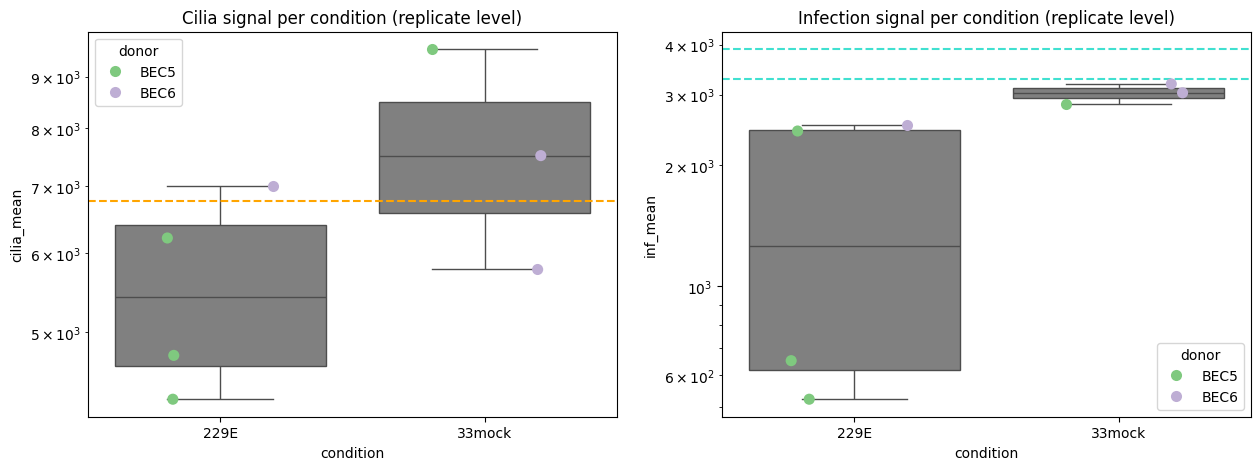

In [68]:
fig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(data=replicate_summary, x="condition", y="cilia_mean", ax=ax[0], log_scale=True, fliersize = 0, color='grey')
sns.boxplot(data=replicate_summary, x="condition", y="inf_mean", ax=ax[1], log_scale=True, fliersize = 0, color='grey')
sns.stripplot(data=replicate_summary, x="condition", y="cilia_mean", hue="donor", palette="Accent", dodge=True, ax=ax[0], log_scale=True, size = 8)
sns.stripplot(data=replicate_summary, x="condition", y="inf_mean", hue="donor", palette="Accent", dodge=True, ax=ax[1], log_scale=True, size = 8)
ax[0].set_title('Cilia signal per condition (replicate level)')
ax[1].set_title('Infection signal per condition (replicate level)')
# Add the threshold lines
for t in inf_threshs:
    ax[1].axhline(10**t, color='turquoise', linestyle='--', label=f'Infection threshold {t:.2f}')
for t in cilia_thresh:
    ax[0].axhline(10**t, color='orange', linestyle='--', label=f'Cilia threshold {t:.2f}')
plt.show()

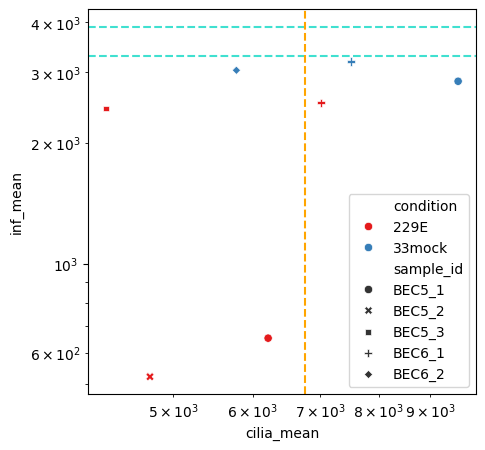

In [69]:
fig, ax = plt.subplots(figsize=(5, 5), dpi= 100)
# Create a scatter plot for the two conditions
sns.scatterplot(data=replicate_summary, x='cilia_mean', y='inf_mean', hue="condition", palette="Set1", style="sample_id", ax=ax)
plt.xscale('log')
plt.yscale('log')
# Add threshold lines
for t in inf_threshs:
    ax.axhline(10**t, color='turquoise', linestyle='--', label=f'Infection threshold {t:.2f}')
for t in cilia_thresh:
    ax.axvline(10**t, color='orange', linestyle='--', label=f'Cilia threshold {t:.2f}')
plt.show()

### Average replicates by donors

In [70]:
donor_summary = df_to_show.groupby(['condition', 'donor']).agg({
    'cilia_mean': 'mean',
    'inf_mean': 'mean',
}).reset_index()
donor_summary

,condition,donor,cilia_mean,inf_mean
0,229E,BEC5,5298.672359,1344.615342
1,229E,BEC6,7011.552276,2516.543877
2,33mock,BEC5,9594.972225,2848.447068
3,33mock,BEC6,6661.801373,3114.265784


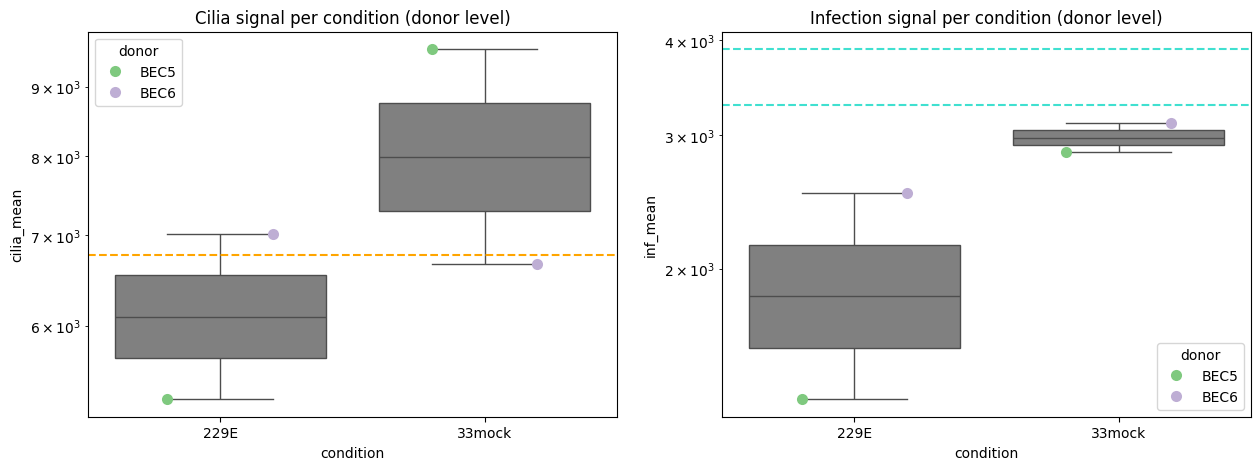

In [71]:
gig, ax = plt.subplots(1,2, figsize=(15, 5))
sns.boxplot(data=donor_summary, x="condition", y="cilia_mean", ax=ax[0], log_scale=True, fliersize = 0, color='grey')
sns.boxplot(data=donor_summary, x="condition", y="inf_mean", ax=ax[1], log_scale=True, fliersize = 0, color='grey')
sns.stripplot(data=donor_summary, x="condition", y="cilia_mean", hue="donor", palette="Accent", dodge=True, ax=ax[0], log_scale=True, size = 8)
sns.stripplot(data=donor_summary, x="condition", y="inf_mean", hue="donor", palette="Accent", dodge=True, ax=ax[1], log_scale=True, size = 8)
ax[0].set_title('Cilia signal per condition (donor level)')
ax[1].set_title('Infection signal per condition (donor level)')
# Add the threshold lines
for t in inf_threshs:
    ax[1].axhline(10**t, color='turquoise', linestyle='--', label=f'Infection threshold {t:.2f}')
for t in cilia_thresh:
    ax[0].axhline(10**t, color='orange', linestyle='--', label=f'Cilia threshold {t:.2f}')
plt.show()

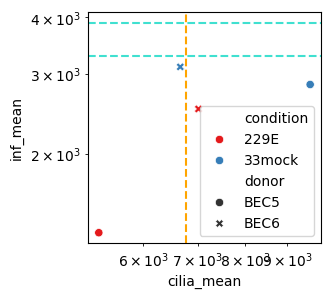

In [72]:
fig, ax = plt.subplots(figsize=(3, 3), dpi= 100)
# Create a scatter plot for the two conditions
sns.scatterplot(data=donor_summary, x='cilia_mean', y='inf_mean', hue="condition", palette="Set1", style="donor", ax=ax)
plt.xscale('log')
plt.yscale('log')
# Add threshold lines
for t in inf_threshs:
    ax.axhline(10**t, color='turquoise', linestyle='--', label=f'Infection threshold {t:.2f}')
for t in cilia_thresh:
    ax.axvline(10**t, color='orange', linestyle='--', label=f'Cilia threshold {t:.2f}')
plt.show()

## Cilia histograms (for finding threshold)

In [73]:
df_to_show = cells_df.copy()
cilia_signals = df_to_show["cilia_mean_log10"].dropna()

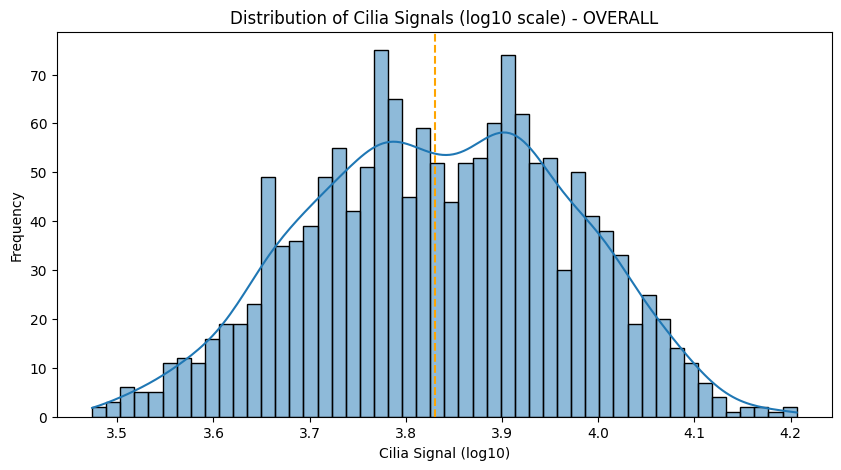

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(cilia_signals, bins=50, kde=True, ax=ax)
ax.set_title('Distribution of Cilia Signals (log10 scale) - OVERALL')
ax.set_xlabel('Cilia Signal (log10)')
ax.set_ylabel('Frequency')
# Add a vertical line for the threshold
for t in cilia_thresh:
    ax.axvline(t, color='orange', linestyle='--', label=f'Cilia threshold {t:.2f}')
plt.show()

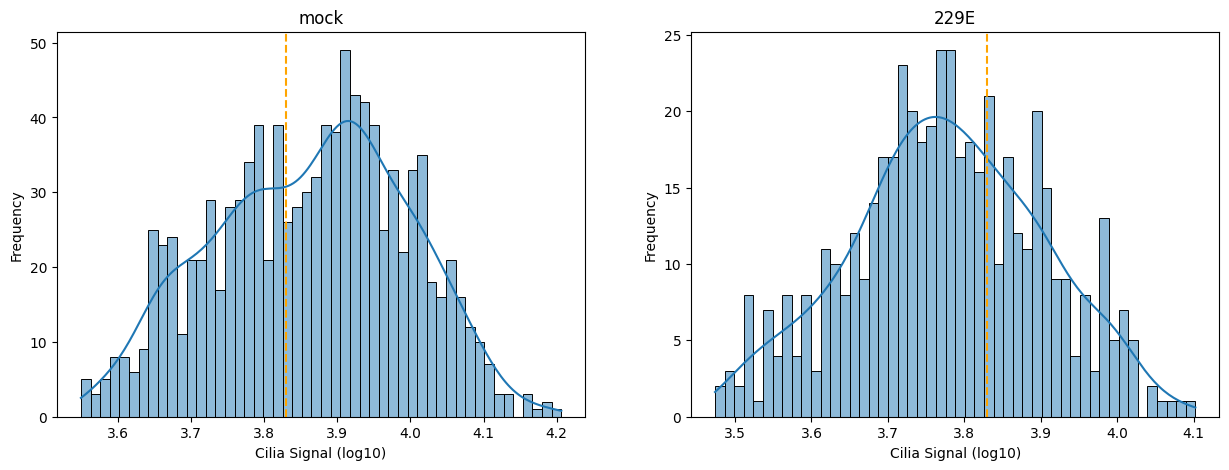

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

for a, cond in zip(ax, ["mock", virus]):
    cilia_signals = df_to_show[df_to_show["condition"].str.contains(cond)]["cilia_mean_log10"].dropna()
    sns.histplot(cilia_signals, bins=50, kde=True, ax=a)
    a.set_title(cond)
    a.set_xlabel('Cilia Signal (log10)')
    a.set_ylabel('Frequency')
    # Add a vertical line for the threshold
    for t in cilia_thresh:
        a.axvline(t, color='orange', linestyle='--', label=f'Cilia threshold {t:.2f}')

plt.show()